# 📘 05_FRM_Make_Pipeline


## 🔎 Introduction
In the previous notebooks, we:
- Preprocessed face images and cropped them.
- Performed exploratory data analysis (EDA) to understand image distributions.
- Extracted **Eigenface features** using PCA.
- Trained and evaluated an **SVM classifier** for gender prediction.

Now, we will **combine all these steps into a single, end-to-end pipeline**.  
The pipeline will:
- Accept a raw face image as input.
- Preprocess it (grayscale, resize, flatten).  
- Transform it using the **trained PCA model**.  
- Predict gender using the **trained SVM model**.  

This will make the workflow **modular, reusable, and ready for deployment** in a Flask application.

---

## 🎯 Objectives
1. **Load Pretrained Models**  
   - PCA model (Eigenfaces) and SVM classifier.

2. **Create Image Preprocessing Function**  
   - Convert new images to **grayscale**, resize to **100x100**, and flatten.

3. **Integrate PCA Transformation**  
   - Transform processed image into **PCA feature space**.

4. **Predict Gender Using SVM**  
   - Generate class label (male/female) for new images.

5. **Build a Reusable Pipeline**  
   - Combine preprocessing, PCA transformation, and SVM prediction into a **single callable function**.

6. **Prepare Pipeline for Flask Deployment**  
   - Ensure the pipeline can handle single images or batches efficiently.

✅ After completing this notebook, we will have a **fully functional, deployable face recognition gender classification pipeline** ready for integration into web applications.


In [1]:
# 📦 Import Required Libraries

import numpy as np
import pandas as pd
import pickle
import cv2
import matplotlib.pyplot as plt
import sklearn


# 📂 Load Pretrained Models


In this step, we load all the models required for the **face recognition gender classification pipeline**:

1. **Haar Cascade Classifier** (`haarcascade_frontalface_default.xml`)  
   - Used to **detect faces** in input images.
   - Provides bounding boxes to crop faces from raw images.

2. **SVM Classifier** (`model_svm.pickle`)  
   - Trained on **PCA-transformed Eigenface features**.
   - Used to **predict gender** (male/female) from extracted features.

3. **PCA Model Dictionary** (`pca_dict.pickle`)  
   - Contains:
     - `pca` → PCA object to transform input images into the **Eigenface feature space**.
     - `mean_face` → Mean face used to **center new images** before PCA transformation.

By loading these models, we prepare the pipeline to **take a new image as input, preprocess it, transform it, and predict gender**.


In [3]:
# Load all pretrained models

# Face detector
haar = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')  

# Trained SVM classifier
model_svm = pickle.load(open('./models/model_svm.pickle', mode='rb'))  

# PCA dictionary (pca object + mean face)
pca_models = pickle.load(open('./models/pca_dict.pickle', mode='rb'))  

# Extract PCA object and mean face
model_pca = pca_models['pca']
mean_face_arr = pca_models['mean_face']

print("✅ Models successfully loaded!")


✅ Models successfully loaded!


# 🏗 Create Face Recognition Pipeline


This cell demonstrates an **end-to-end pipeline** for predicting the gender of faces in an image:

### Steps:

1. **Read Image**  
   - Load the test image in BGR format using OpenCV.

2. **Convert to Grayscale**  
   - Faces are processed in grayscale for consistency with training.

3. **Detect Faces**  
   - Use the **Haar Cascade Classifier** to detect face bounding boxes.

4. **Normalize Pixel Values**  
   - Scale pixel values to [0,1] range.

5. **Resize Image to 100x100**  
   - Maintain consistency with the training image size.

6. **Flatten Image**  
   - Convert 2D image into 1D array (1 x 10,000).

7. **Subtract Mean Face**  
   - Center the input image using the **mean face** from PCA training.

8. **PCA Transformation (Eigenface)**  
   - Transform the mean-centered image to the **Eigenface feature space**.

9. **Inverse PCA for Visualization**  
   - Optionally visualize the reconstructed image from PCA components.

10. **SVM Prediction**  
    - Predict gender using the **trained SVM model**.  
    - Obtain **probability scores**.

11. **Annotate Image**  
    - Draw bounding boxes with color-coded results (male/female).  
    - Display predicted label and confidence score.

12. **Generate Output Dictionary**  
    - Contains `roi`, `eig_img`, `prediction_name`, and `score` for each detected face.

---

This pipeline is **modular** and can handle **multiple faces** in a single image, producing both **visual and structured outputs**.


In [6]:
# Step-01: Read image (BGR)
img = cv2.imread('./data/test_images/getty_test.jpg')  

# Step-02: Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

# Step-03: Detect faces using Haar Cascade
faces = haar.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=3)

# Initialize list to store predictions
predictions = []

# Process each detected face
for x, y, w, h in faces:
    
    # Crop the face region
    roi = gray[y:y+h, x:x+w]
    
    # Step-04: Normalize pixel values to 0-1
    roi = roi / 255.0
    
    # Step-05: Resize to 100x100
    if roi.shape[1] > 100:
        roi_resize = cv2.resize(roi, (100, 100), interpolation=cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi, (100, 100), interpolation=cv2.INTER_CUBIC)
        
    # Step-06: Flatten image (1x10000)
    roi_flatten = roi_resize.reshape(1, 10000)
    
    # Step-07: Subtract mean face
    roi_mean = roi_flatten - mean_face_arr  
    
    # Step-08: PCA transformation (Eigenface)
    eigen_image = model_pca.transform(roi_mean)
    
    # Step-09: Inverse PCA for visualization (optional)
    eig_img = model_pca.inverse_transform(eigen_image)
    
    # Step-10: Predict gender using SVM
    result = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
    
    # Step-11: Annotate image with prediction
    text = f"{result[0]} : {int(prob_score_max*100)}%"
    color = (255, 255, 0) if result[0] == 'male' else (255, 0, 255)
    
    cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    cv2.rectangle(img, (x, y-40), (x+w, y), color, -1)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),5)
    
    # Store prediction info
    output = {
        'roi': roi,
        'eig_img': eig_img,
        'prediction_name': result[0],
        'score': prob_score_max
    }
    predictions.append(output)


# 📊 Display Predictions and Generate Report

In this step, we **visualize the results** of the face recognition gender classification pipeline:

1. **Annotated Image**  
   - Display the original image with **bounding boxes** around detected faces.  
   - Show predicted **gender** and **confidence score** on each face.

2. **Face Crops and Eigenfaces**  
   - For each detected face, display:
     - The **grayscale cropped face**.
     - The **reconstructed eigenface** obtained from PCA transformation.  

3. **Prediction Report**  
   - Print predicted **gender** and **confidence score** for each face.
   - This allows a **clear and detailed understanding** of how the pipeline processes each detected face.


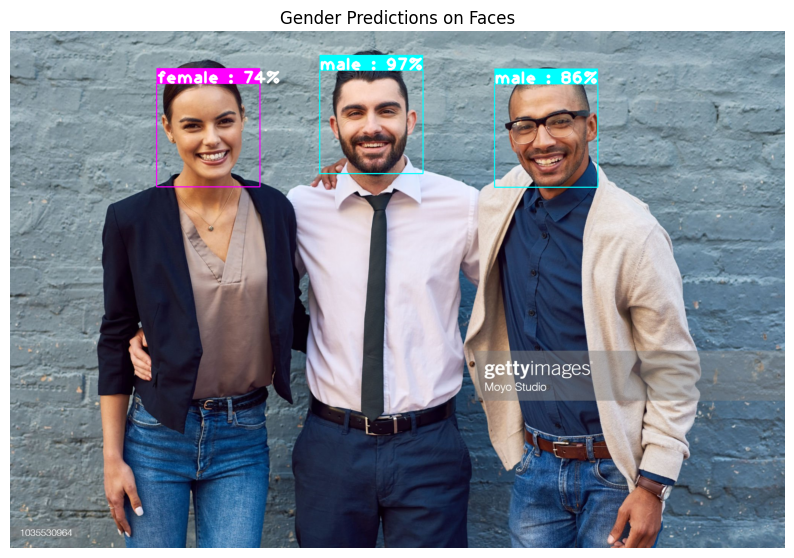

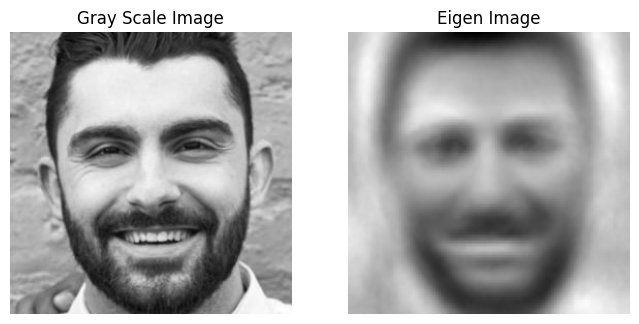

Face 1:
Predicted Gender : male
Confidence Score : 97.87 %
--------------------------------------------------------------------------------


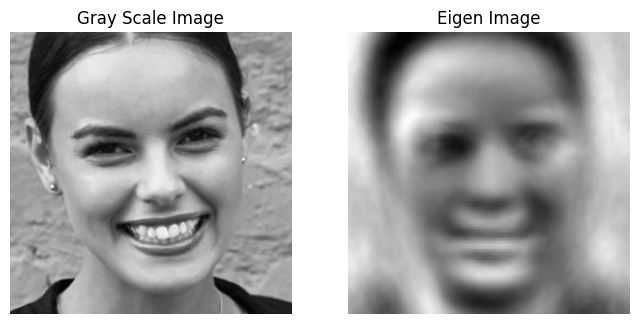

Face 2:
Predicted Gender : female
Confidence Score : 74.48 %
--------------------------------------------------------------------------------


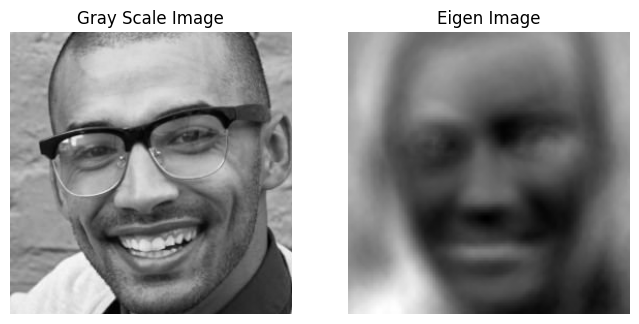

Face 3:
Predicted Gender : male
Confidence Score : 86.83 %
--------------------------------------------------------------------------------


In [9]:
# Convert BGR to RGB for proper display with matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the final image with bounding boxes and predictions
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Gender Predictions on Faces")
plt.show()

# Generate detailed report for each detected face
for i, pred in enumerate(predictions, 1):
    roi_gray = pred['roi']                   # Grayscale face crop
    eig_img = pred['eig_img'].reshape(100, 100)  # Eigenface reconstruction
    
    # Display side-by-side: Grayscale and Eigen Image
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(roi_gray, cmap='gray')
    plt.title('Gray Scale Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(eig_img, cmap='gray')
    plt.title('Eigen Image')
    plt.axis('off')
    
    plt.show()
    
    # Print prediction info
    print(f"Face {i}:")
    print(f"Predicted Gender : {pred['prediction_name']}")
    print(f"Confidence Score : {pred['score']*100:.2f} %")
    print('-'*80)


# ✅ Conclusion

In this notebook, we successfully **built an end-to-end face recognition pipeline** for gender classification:

1. **Face Detection:**  
   - Used **Haar Cascade Classifier** to detect faces in images.

2. **Preprocessing:**  
   - Converted faces to grayscale.  
   - Resized to 100x100 pixels and normalized pixel values.  
   - Flattened images and subtracted the **mean face**.

3. **Feature Extraction:**  
   - Applied **PCA** (Eigenface method) to transform faces into feature space.

4. **Prediction:**  
   - Predicted gender using the **trained SVM model**.  
   - Calculated probability scores for each prediction.

5. **Visualization & Report:**  
   - Annotated input images with bounding boxes, predicted gender, and confidence.  
   - Displayed both grayscale faces and reconstructed eigenfaces for interpretability.  
   - Generated a structured report for each detected face.

**Outcome:**  
- The pipeline is fully **modular**, can handle multiple faces in an image, and provides both **visual and tabular outputs** for analysis.  
- It is ready for integration into a **Flask application** for real-time gender detection.

---

**Next Step:**  
- Deploy this pipeline as a **real-time web application** using **Flask** in the next notebook: `06_FRM_Deploy_Flask`.  
- Users will be able to **upload images** or use **camera input** to get live predictions.
